In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
%matplotlib widget

We will focus on the flat analysis in this notebook so we have to upload the flat list we prepared in the first notebook.

In [3]:
flat_list = np.genfromtxt('./group10_WASP-135_20190803/flat/flat.list', dtype=str)
#print(flat_list) #To check that it works correctly


In the first lecture we computed the error associated with the bias and the readout noise obtained when analyzing the bias frames. We need to upload those values, as well as the gain.

From last lecture:

Julian date       : 2458699.475185 JD

CCD Gain          : 1.91 [e/ADU] 

CCD Readout noise : 7.10 [e]

We chose the value 1.33 for the bias_std because it's the one the fits the data better at the end of the first notebook

In [4]:
median_bias = pickle.load(open("median_bias.p", "rb"))
bias_std = 1.33 # [e] = photoelectrons
readout_noise = 7.10 # [e] = photoelectrons
gain = 1.91 #[e/ADU] from the header file

As safety check we gather again those values from the flat headers

In [5]:
flat00_fits = fits.open('./group10_WASP-135_20190803/flat/'+flat_list[0]) #Open the first flat file
flat00_data = flat00_fits[0].data * gain

print('CCD Gain          : {0:4.2f} {1:.8s}'.format(flat00_fits[0].header['GAIN'], flat00_fits[0].header.comments['GAIN']))
print('CCD Readout Noise : {0:4.2f} {1:.3s}'.format(flat00_fits[0].header['RDNOISE'], flat00_fits[0].header.comments['RDNOISE']))
print('Shape of the FITS image from the header : {0:4d} x {1:4d} pixels'.format(flat00_fits[0].header['NAXIS1'], flat00_fits[0].header['NAXIS2']))


CCD Gain          : 1.91 [e/ADU] 
CCD Readout Noise : 7.10 [e]
Shape of the FITS image from the header :  521 x  119 pixels


### Overscan
If we let matplotlib automatically choose the range of the colorbar and we plot the counts as a funztion of the column number, we can see that there are two strips at the margins of the image with a much lower number of counts. Those columns are known as $\textbf{overscans}$.
The overscan regions of a CCD form as a part of the sensor is covered and does not receive any light, thus acting like a local bias. One can use the values in the overscan as bias when the bias frames are not available. Generally speaking, you can replace the median bias with the overscan only if there is no variation of bias along the horizontal axis, otherwise it is preferable to compute the median bias from the bias frames if available.

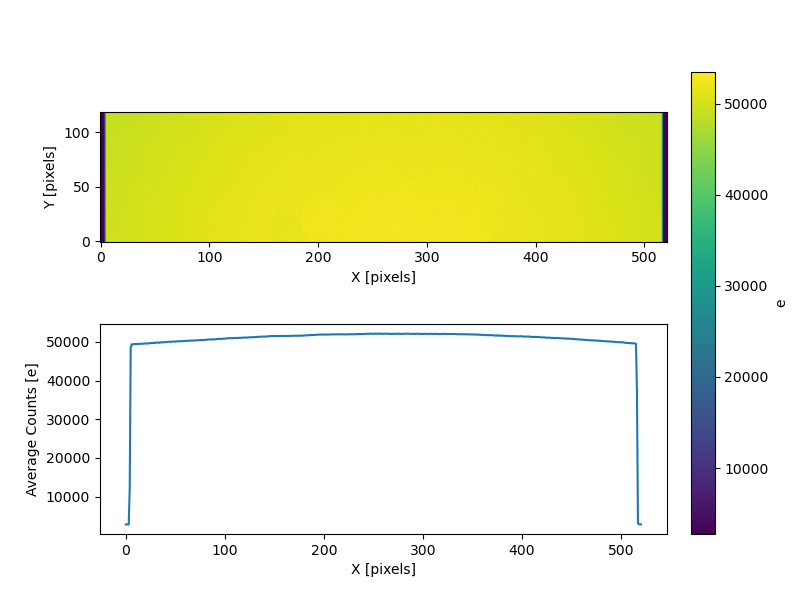

In [6]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) #Creiamo un subplot con due grafici
im1 = ax[0].imshow(flat00_data, origin='lower') #Il primo plot mostra i conteggi del primo flat file che abbiamo caricato prima in un'immagine 2D
median_column = np.average(flat00_data, axis=0) #Calcoliamo la media dei dati del primo flat facendo scorrere le righe (quindi otteniamo un valore per colonna)
im2 = ax[1].plot(median_column) #Il secondo plot mostra la mediana dei conteggi in funzione delle colonne (Ci aspettiamo un valore basso agli estremi e alto al centro)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04) #Aggiungiamo una colorbar al primo grafico
cbar.set_label("e") #Aggiungiamo una label alla color bar che in questo caso misura i conteggi, ossia photoelectrons

#Aggiungiamo una label agli assi del primo grafico (pixel in un'immagine 2D)
ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

#Nel secondo grafico abbiamo pixel sulla X (numero della colonna) e la mediana dei photoelectrons di una colonna su Y
ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average Counts [e]')
plt.show()

### Dealing with Overscans
Their presence is a problem when we perform statistics on the whole frame. We can exclude the outer columns from the analysis when computing full-frame statistics and visualization. Let's plot our frame again but we compute the minimum and maximum values of counts, excluding the overscan regions.
Also this time we set the limits for the colorbar and for the vertical axis of the second plot.

48502.54 53460.899999999994


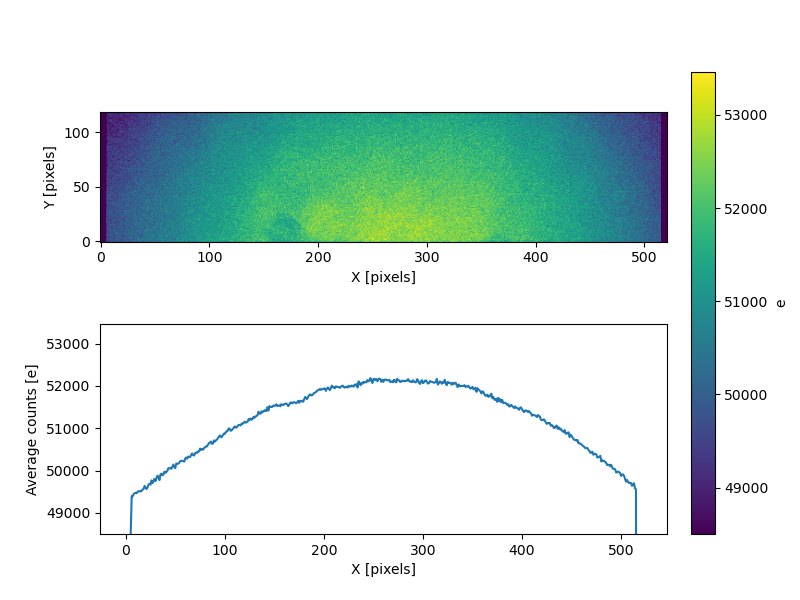

In [7]:
vmin = np.amin(flat00_data[:, 12:-12]) #Minimo tra tutte le righe, le colonne dalla 12 alla -12
vmax = np.amax(flat00_data[:, 12:-12])
print(vmin, vmax)

fig, ax = plt.subplots(2,1, figsize=(8,6))
im1 = ax[0].imshow(flat00_data, origin='lower', vmin=vmin, vmax=vmax)
median_column = np.average(flat00_data, axis=0)
im2 = ax[1].plot(median_column)

#Set the plot limits
ax[1].set_ylim(vmin, vmax)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad = 0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

### Flat Calibration
The purpose of lat calibration is to compensate for any non-uniformity in the response of the CCD to light. This can be caused by:

1) variations in the sensitivity of pixels in the detector.
2) dust on the detector
3) vignetting
4) anything in the optical path that affects how much light reaches the sensor.

To fix this non-uniformity we take an image with uniform illumination and use that to measure the CCD's response. When illuminating the CCD, we want to reach the highest S/N ratio for every pixel. As the photon noise goes with the square root of the flux, we need to achieve very high counts without reaching saturation.
If we divide the science frames by these very high counts we will produce unrealistically small photoelectron fluxes. Since we are interested in the relative response, and not the absolute efficiency of each pizel, we can express the flat correction as the correction value relative to the median response over a selected sample of pixels.

- First we initialize a 3D $\textit{stack}$ with all the frames and we correct them from bias.
- Next we compute the reference value of each frame by taking the median within a box of 50x50 pixels in the centre of each frame.


In [8]:
n_images = len(flat_list) # Estraggo il numero di immagini nella lista flat
flat00_nparray_dim00, flat00_nparray_dim01 = np.shape(flat00_data) # Estraggo la dimensione dei vari frame

stack = np.empty([n_images, flat00_nparray_dim00, flat00_nparray_dim01]) #Creo uno stack di dimensione (N, x, y)


for i, flat_name in enumerate(flat_list):

    '''In questo ciclo for apro temporaneamente ciascuno dei flat, lo moltiplico per il gain e sotraggo
    il median bias calcolato. I flat corretti vengono poi aggiunti allo stack.'''

    flat_temp = fits.open('./group10_WASP-135_20190803/flat/' + flat_name)
    stack[i, :, :] = flat_temp[0].data * flat_temp[0].header['GAIN'] - median_bias
    flat_temp.close()

windows_size = 50

# x0, x1, y0, y1 rappresentano le coordinate dei 4 angoli della finestra.
# Ricordiamo che dim01 è x e dim00 è y.
x0 = np.int16(flat00_nparray_dim01/2 - windows_size/2)
x1 = np.int16(flat00_nparray_dim01/2 + windows_size/2)
y0 = np.int16(flat00_nparray_dim00/2 - windows_size/2)
y1 = np.int16(flat00_nparray_dim00/2 + windows_size/2)

print('Coordinates of the box: x from {0} to {1}, y from {2}, to {3}'.format(x0, x1, y0, y1))


Coordinates of the box: x from 235 to 285, y from 34, to 84


In the case of the bias frame, we wanted to compute the median across the 30 bias frames for each pixel of the sensor, so we set axis = 0 and the ouput had dimension (x, y). Here we want to compute the median of a given set of pixels for each frame so we will get an array of dimension 30 (one median for each frame).
For this purpose we will use tuples (collection which is ordered and unchangeable).

We can also compute an estimated error by computing the standard deviation inside the box (which gives the error on each pixel) and then divide by the square root of N_pixels. (This is $\textbf{not the correct way}$ but still a good estimate).

$ \epsilon = \frac{\sigma}{\sqrt{N}} = \frac{\sqrt{\sum_{i=0}^{N}(x_i - \mu)^2}}{\sqrt{N}\sqrt{N}} = \frac{\sqrt{\sum_{i=0}^{N}(x_i - \mu)^2}}{N} $

 **Standard deviation vs. error on the mean**  
   - The standard deviation of a set of values measures the spread of data around their mean. It tells us how individual pixel values vary from the average.  
   - However, if we want to estimate how uncertain the mean value is for the selected region, we must compute the error on the mean, given by:  
     $ \sigma_{\text{mean}} = \frac{\sigma}{\sqrt{N}} $  
     where:  
     - $ \sigma $ is the standard deviation of the pixels in the selected region.  
     - $ N $ is the number of pixels in the region (e.g., a $50 \times 50$ window used in the file).



In [9]:
normalization_factors = np.median(stack[:, y0:y1, x0:x1], axis=(1,2))
print('Number of normalization factors (must be = n_images): {0}'.format(np.shape(normalization_factors)))
print(normalization_factors)

normalization_factors_std = np.std(stack[:, y0:y1, x0:x1], axis=(1,2)) / np.sqrt(windows_size**2)
print(normalization_factors_std)


Number of normalization factors (must be = n_images): (30,)
[49350.58   49602.7    49356.31   49631.35   49321.93   49717.3
 49306.1725 49692.47   49381.14   49699.6325 49350.58   49723.985
 49310.47   49719.21   49260.81   49681.01   49359.175  49718.7325
 49302.83   49725.4175 49282.2975 49708.2275 49377.32   49677.19
 49339.12   49727.805  49309.9925 49709.1825 49354.4    49653.7925]
[6.05514439 6.08091806 6.09873558 6.18314582 6.1714122  6.18526177
 6.20062521 6.16539033 6.00276214 6.26069453 6.11266668 6.19926022
 6.17200608 6.18223223 6.00906988 6.13650778 6.13757292 6.18965133
 6.12218129 6.09681002 6.21233366 6.1520316  6.02996975 6.05063412
 6.05671177 6.15275319 6.02553232 6.12604223 5.95891624 6.16013588]


Now we plot the normalization factors with their respective errors. We expect them to be constant from one image to another since we would expect to measure the same flux on each pixel for every image. The lamp is in fact the same for all the images.
In the errorbar plot, $\texttt{fmt}$ indicates the type of marker (circle) and $\texttt{ms}$ its size (2).

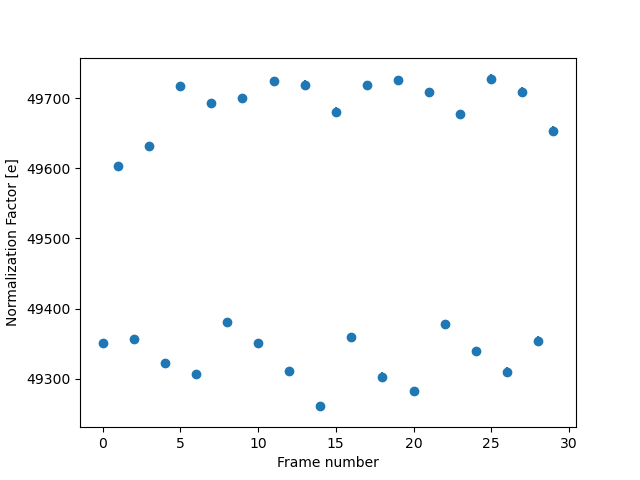

In [10]:
plt.figure()
x_frame = np.arange(0, n_images, 1) #Creo una lista di numeri che va da 0 a N a intervalli di 1
plt.scatter(x_frame, normalization_factors) #Scatter plot dei miei normalization factors per le N immagini
plt.errorbar(x_frame, normalization_factors, normalization_factors_std, fmt='o', ms=2)
plt.xlabel('Frame number')
plt.ylabel('Normalization Factor [e]')
plt.show()

We can see that the normalization factor is not constant. These oscillations are caused by a lamp problem discovered after this observations were taken. This is the main reason why we perform the normalization before computing the median flat.

If it was constant, the normalization would not have mattered.

### Flat Normalization
To normalize each frame we can either:
1. Iterate along the frame and perform the operation
2. Use the broadcasting feature which allows arithmetic operations between arrays with different shapes. Broadcasting starts with the rightmost dimension and works its way left. In our case normalization_factors has the same dimension as the leftmost dimension of stack, respectively (N, 50, 50) and (N, x, y). We can fix this my taking the transpose of the stack. 

In [11]:
'''First Method: iteration'''
stack_normalized_iter = stack * 0 #Produciamo una copia dello stack popolato da soli 0.
for i in range(n_images):
    stack_normalized_iter[i,:,:] = stack[i,:,:] / normalization_factors[i]

'''Second Method: Broadcasting'''
print("shape of stack array           : ", np.shape(stack))
print("shape of transposed stack array: ", np.shape(stack.T))

#Ora possiamo svolgere l'operazione e poi riportare la matrice alla sua forma originale
stack_normalized = (stack.T / normalization_factors).T

#Verifichiamo che i due metodi producano lo stesso risultato
print("Maximum absolute difference between the two arrays: {0:2.6e}".format(np.max(np.abs(stack_normalized_iter - stack_normalized))))


shape of stack array           :  (30, 119, 521)
shape of transposed stack array:  (521, 119, 30)
Maximum absolute difference between the two arrays: 0.000000e+00


### Median Flat
We can now compute the median normalized flat and store it in our computer.

In [12]:
median_normalized_flat = np.median(stack_normalized, axis=0)

pickle.dump(median_normalized_flat, open("median_normalized_flat.p", "wb"))
pickle.dump(stack_normalized, open("flat_normalized_stack.p", "wb"))
pickle.dump(normalization_factors, open("flat_normalization_factors.p", "wb"))
pickle.dump(stack, open("flat_stack.p", "wb"))

Let's plot the results

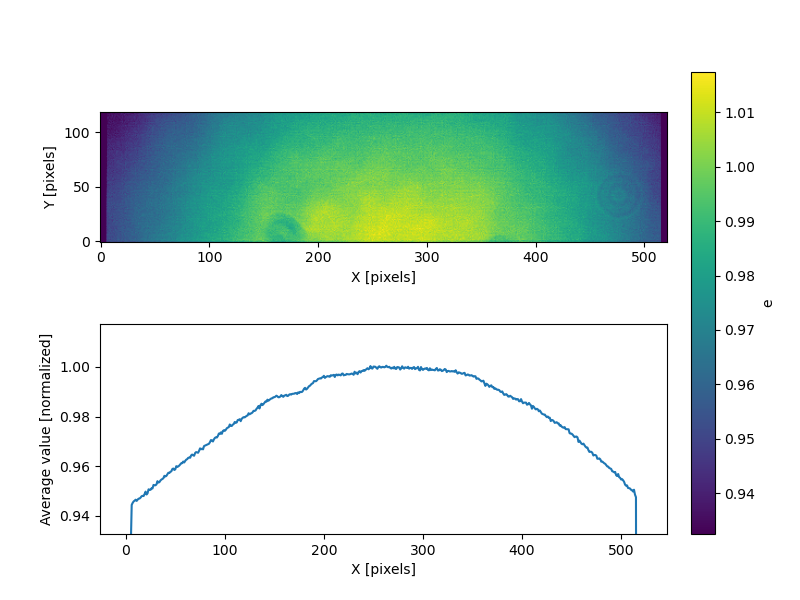

In [14]:
#Prendiamo valore massimo e minimo del normalized flat escludendo i bordi
nmin = np.amin(median_normalized_flat[:, 12:-12])
nmax = np.amax(median_normalized_flat[:, 12:-12])

fig, ax = plt.subplots(2,1, figsize=(8,6))
im1 = ax[0].imshow(median_normalized_flat, origin='lower', vmin=nmin, vmax=nmax)
median_column = np.average(median_normalized_flat, axis=0) #Prendo la media fra le varie immagini (asse 0)
im2 = ax[1].plot(median_column)

ax[1].set_ylim(nmin, nmax)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average value [normalized]')
plt.show()

### Error Propagation
We have three contributors to the error:
1. The readout noise (already computed in 01 - Bias Analysis)
2. The error associated with the median bias frame (already computed in 01 - Bias Analysis)
3. The photon noise associated with the flux of the lamp.

When photons arrive at the detector during an exposure, they do so with a constant mean rate and independently of previous arrivals. This means that the detection of one photon does not influence the detection of another, making the process follow a Poisson distribution.

A Poisson process describes events that:
1. Occur independently from each other.
2. Have a constant probability of occurring over time.
3. Can be counted as discrete events.

Since photons arrive at the CCD randomly but at a steady average rate, the total number of detected photons follows a Poisson distribution.

A fundamental property of the Poisson distribution is that its variance is equal to the mean:

$ \text{Var}(N) = \langle N \rangle $

where:
- $N$ is the number of detected photons.
- $\langle N \rangle$ is the average number of photons detected in a given interval.

This means that the uncertainty (standard deviation) associated with the detected number of photons is:

$ \sigma = \sqrt{N} $

For a pixel receiving an average of 1000 photons, the variance is also 1000, and the standard deviation is:

$ \sigma = \sqrt{1000} \approx 31.6 $

Since the bias value has already been removed from the image, the photon noise contribution is simply given by the square root of the measured signal:

```python
photon_noise = np.sqrt(np.abs(stack))


In [16]:
photon_noise = np.sqrt(np.abs(stack))

Since the errors are independent, their propagation follows the general formula:

$ \sigma_{\text{total}} = \sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2} $

where:
- $ \sigma_1 $ is the readout noise.
- $ \sigma_2 $ is the error associated with the median bias frame.
- $ \sigma_3 $ is the photon noise.


In [19]:
stack_error = np.sqrt(readout_noise**2 + bias_std**2 + photon_noise**2)

# La normalizzazione è semplicemente la divisione per una costante:
stack_normalized_error = (stack_error.T / normalization_factors).T


To compute the error associated with the median flat, we approximate the median function with the mean function, which has an analytical expression and can be used with the error propagation formula.

We assume that the noise follows a white noise regime, meaning that pixel fluctuations are independent and uncorrelated. If this assumption were not valid, a different error propagation method would be required.

The mean of a set of values is defined as:

$ f = \frac{\sum\limits_{i=1}^{N} f_i}{N} $

To propagate the error, we use the general formula:

$ \sigma_F^2 = \sum\limits_{i=1}^{N} \left( \frac{\partial F}{\partial x_i} \sigma_i \right)^2 $

Applying this to the mean function:

$ \frac{\partial f}{\partial f_i} = \frac{1}{N} $

$ \sigma_f^2 = \frac{1}{N^2} \sum\limits_{i=1}^{N} \sigma_i^2 $

Taking the square root:

$ \sigma_f = \frac{\sqrt{\sum\limits_{i=1}^{N} \sigma_i^2}}{N} $

This formula allows us to estimate the uncertainty in the median flat, assuming the noise characteristics justify the use of the mean for error propagation. If noise correlations exist, a different approach should be used.


In [20]:
median_normalized_flat_errors = np.sum(stack_normalized_error**2, axis=0) / n_images
pickle.dump(median_normalized_flat_errors, open("median_normalized_flat_errors.p", "wb"))


### Statistics on the Flat
Why normalize first, and then compute the median? Can I change the order?

If the flux of the lamp is constant, the two distributions should be extremely similar, almost identical.

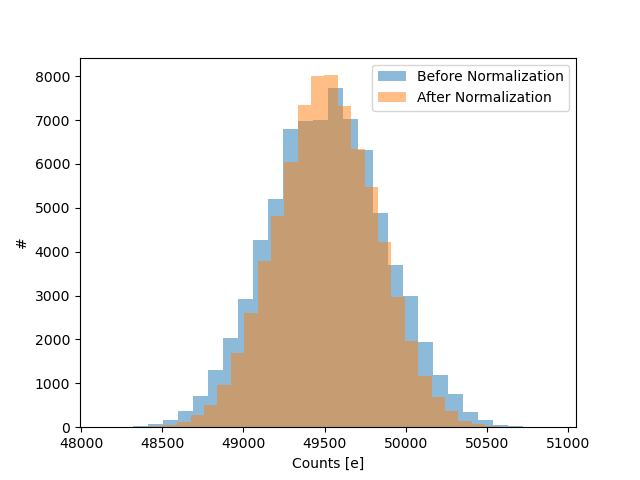

In [21]:
mean_normalization = np.mean(normalization_factors) #calcolo la media dei fattori di normalizzazione

plt.figure()
plt.hist(stack[:, y0:y1, x0:x1].flatten(), bins=30, alpha=0.5, label='Before Normalization')
plt.hist(stack_normalized[:, y0:y1, x0:x1].flatten()*mean_normalization, bins=30, alpha=0.5, label='After Normalization')
plt.xlabel('Counts [e]')
plt.ylabel('#')
plt.legend()
plt.show()

There is a clear difference between the two distributions. If we want to understand the reason for this difference we can compare it with the theoretical distribution that they should have is the variation was due to photon noise alone.

##### Why do we now use a normal distribution instead of Poisson?

Previously, we used a Poisson distribution because the number of photons collected by each pixel follows a Poisson process. This means that for a single pixel, the variance of the detected photons is equal to the mean.

However, when computing the **normalization factors**, we take the **mean over a region of pixels** (e.g., a $50 \times 50$ window). According to the **Central Limit Theorem**, the average of many independent Poisson-distributed values tends to follow a normal distribution.  

Thus, the fluctuations in the normalization factors should follow a Gaussian with a standard deviation given by:  

$ \sigma = \sqrt{f_{\text{avg}}} $

where $ f_{\text{avg}} $ is the mean flux in the selected region.

This allows us to compare the observed distribution of normalization factors with the expected normal distribution. If the observed fluctuations are larger than expected, it indicates an additional source of variation beyond photon noise.


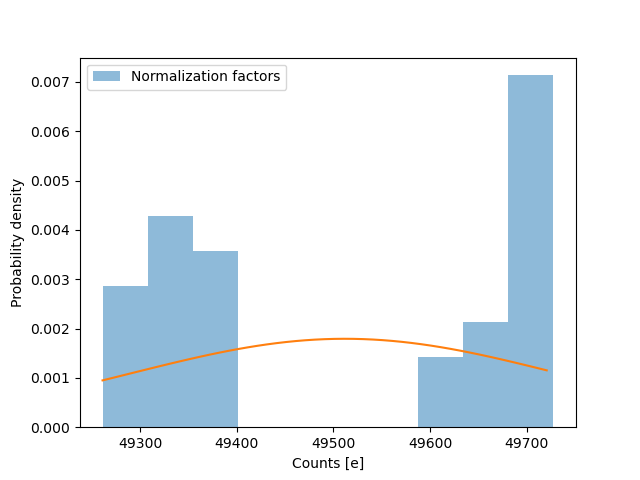

In [22]:
sigma_mean_normalization = np.sqrt(mean_normalization) #Applico la formula

#x contiene i valori dei normalization factors, dal minimo al massimo, a intervalli di 10
x = np.arange(np.amin(normalization_factors), np.amax(normalization_factors), 10)

#y è la distribuzione Gaussiana costruita su x 
y=1./(sigma_mean_normalization * np.sqrt(2 * np.pi)) * np.exp(-(x - mean_normalization)**2 / (2* sigma_mean_normalization**2))

#Plottiamo i normalization_factors vs la gaussiana
plt.figure()
plt.hist(normalization_factors,alpha=0.5, density=True, label='Normalization factors')
plt.plot(x,y)
plt.xlabel('Counts [e]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

It appears clear that the variation in the illumination by the flat lamp is not consistent with photon noise alone. After technical investigation, a fluctuations in the voltage of the lamp has been discovered.

For this reason, we performed the normalization, i.e., removing the variation of illumination with time, before computing the median.